**NN Classification**

Gian Favero | ECSE 556 | December 1st, 2023

In [1]:
# Import MNIST dataset
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = train_images.reshape((60000, 28*28)) # Reshape the data into the shape the network expects
train_images = train_images.astype('float32') / 255 # Normalize the data to [0, 1]
test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype('float32') / 255

# Categorically encode the labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

2023-12-01 18:21:36.045125: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 18:21:36.287842: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 18:21:36.287905: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 18:21:36.288472: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 18:21:36.384298: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 18:21:36.386871: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Build the network
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import initializers
import numpy as np
import tensorflow as tf

# Set random seed
np.random.seed(0)

def leaky_relu(z, alpha=0.01):
    return tf.maximum(alpha*z, z)

def sigmoid(z):
    return 1 / (1 + tf.exp(-z))

def classifier_model(layer_size, num_layers, activation, input_dim, dropout_rate=0.2):
    network = models.Sequential()

    # Add first layer
    network.add(layers.Dense(layer_size, 
                             input_dim=input_dim, 
                             activation=activation, 
                             kernel_initializer=initializers.RandomNormal(stddev=0.01)))

    for _ in range(num_layers):
        network.add(layers.Dense(layer_size, 
                                 activation=activation, 
                                 kernel_initializer=initializers.RandomNormal(stddev=0.01)))
        network.add(BatchNormalization())
        network.add(layers.Dropout(dropout_rate))
    network.add(layers.Dense(10, activation='softmax')) # Add the output layer

    # Compile the network
    network.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    
    return network

Create the networks

In [3]:
model_1 = classifier_model(
    layer_size=256,
    num_layers=50, 
    input_dim=28*28,
    activation=leaky_relu,
    )

model_2 = classifier_model(
    layer_size=256,
    num_layers=20, 
    input_dim=28*28,
    activation=leaky_relu,
    )

model_3 = classifier_model(
    layer_size=256,
    num_layers=10, 
    input_dim=28*28,
    activation=sigmoid,
    )

model_4 = classifier_model(
    layer_size=256,
    num_layers=5, 
    input_dim=28*28,
    activation=sigmoid,
    )

models = [model_1, model_2, model_3, model_4]

2023-12-01 18:21:39.952816: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Train (or load) the models

In [4]:
'''histories = []

for model in models:
    with tf.device('/gpu:4'):
        history = model.fit(train_images, 
                            train_labels, 
                            epochs=20, 
                            batch_size=128, 
                            validation_data=(test_images, test_labels),
        )
    histories.append(history)
    
# Save the histories
with open('MNIST/histories.json', 'w') as f:
    json.dump(histories, f)'''

"histories = []\n\nfor model in models:\n    with tf.device('/gpu:4'):\n        history = model.fit(train_images, \n                            train_labels, \n                            epochs=20, \n                            batch_size=128, \n                            validation_data=(test_images, test_labels),\n        )\n    histories.append(history)\n    \n# Save the histories\nwith open('MNIST/histories.json', 'w') as f:\n    json.dump(histories, f)"

50 layers, Leaky ReLU Loss after 20 epochs: 1.7606
50 layers, Leaky ReLU Accuracy after 20 epochs: 0.3278
20 layers, Leaky ReLU Loss after 20 epochs: 0.1132
20 layers, Leaky ReLU Accuracy after 20 epochs: 0.9782
10 layers, Sigmoid Loss after 20 epochs: 0.1287
10 layers, Sigmoid Accuracy after 20 epochs: 0.9713
5 layers, Sigmoid Loss after 20 epochs: 0.1313
5 layers, Sigmoid Accuracy after 20 epochs: 0.9683


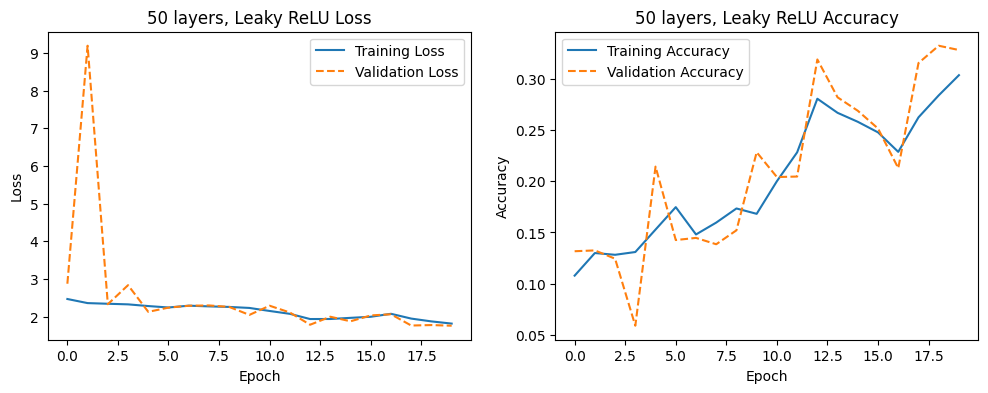

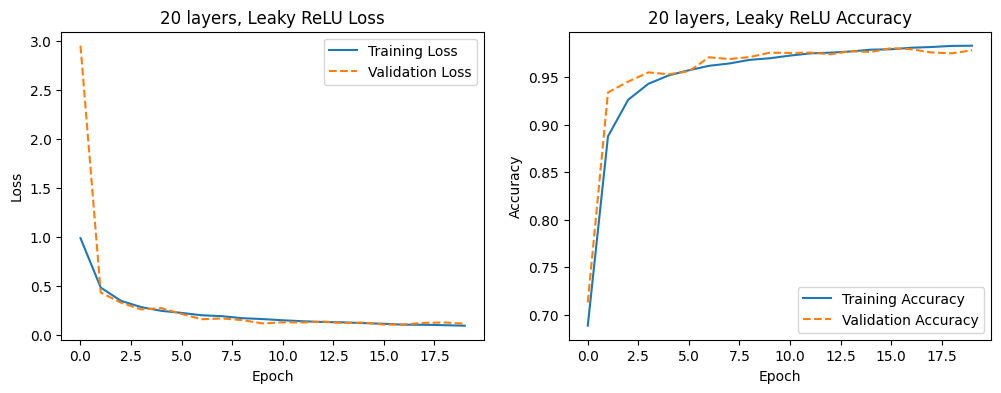

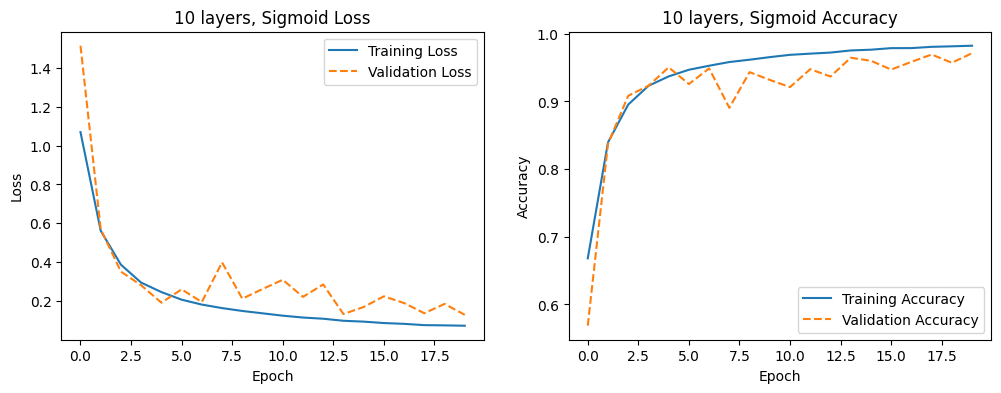

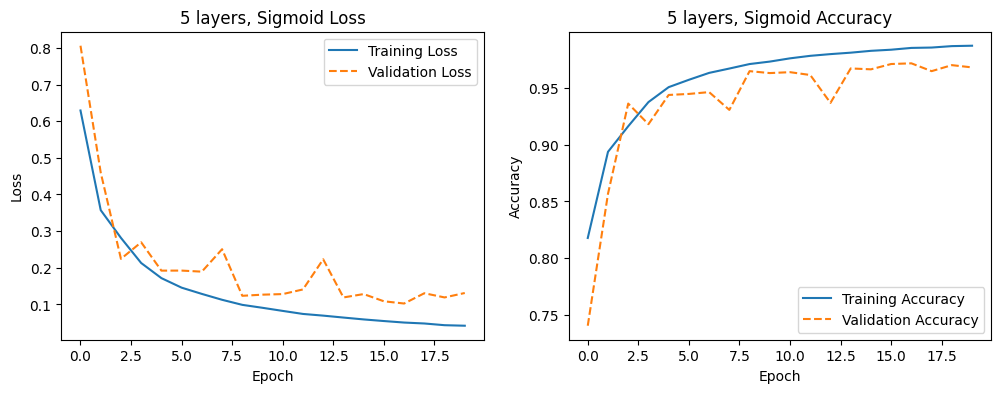

In [5]:
import matplotlib.pyplot as plt
import json

# Load histories
histories = []

with open('MNIST/histories.json', 'r') as f:
    histories = json.load(f)

# Map numbers to model names
model_names = {
    0: '50 layers, Leaky ReLU',
    1: '20 layers, Leaky ReLU',
    2: '10 layers, Sigmoid',
    3: '5 layers, Sigmoid',
}

for i, history in enumerate(histories):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['loss'], label='Training Loss')
    ax1.plot(history['val_loss'], linestyle='--', label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_names[i]} Loss')
    ax1.legend()

    ax2.plot(history['accuracy'], label='Training Accuracy')
    ax2.plot(history['val_accuracy'], linestyle='--', label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{model_names[i]} Accuracy')
    ax2.legend()

    plt.savefig(f'MNIST/model_{i+1}.png')

    print(f'{model_names[i]} Loss after 20 epochs: {round(history["val_loss"][-1], 4)}')
    print(f'{model_names[i]} Accuracy after 20 epochs: {round(history["val_accuracy"][-1], 4)}')